# Threaded data acquisition

In this notebook, we will explore how threading can be used with measurement context manager or dond functions for faster data acquisition. It is important to note that, the threading QCoDeS provideds happens per instrument. Meaning, per instrument one thread is created and all parameters from same instrument gets assigned to the same thread for data acquizition. It is generally not safe for more than one thread to communicate with the same instrument at the same time.

Let us begin with some necessary imports.

In [1]:
%matplotlib inline

import time
from pathlib import Path

import numpy as np

from qcodes.dataset import (
    Measurement,
    ThreadPoolParamsCaller,
    do1d,
    initialise_or_create_database_at,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.instrument_drivers.mock_instruments import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
from qcodes.parameters import Parameter
from qcodes.validators import Numbers


Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/240521-16445-qcodes.log


Now, setup some instruments!

In [2]:
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm1 = DummyInstrumentWithMeasurement(name='dmm1', setter_instr=dac)
dmm2 = DummyInstrumentWithMeasurement(name='dmm2', setter_instr=dac)

In [3]:
class SleepyDmmExponentialParameter(Parameter):
    def __init__(self, name, **kwargs):
        super().__init__(name, **kwargs)
        self._ed = self._exponential_decay(5, 0.2)
        next(self._ed)

    def get_raw(self):
        dac = self.root_instrument._setter_instr
        val = self._ed.send(dac.ch1())
        next(self._ed)
        time.sleep(0.1)
        return val

    @staticmethod
    def _exponential_decay(a: float, b: float):
        x = 0
        while True:
            x = yield
            yield a * np.exp(-b * x) + 0.02 * a * np.random.randn()

The above parameter class is made to return data with a delay on purpose with help of `time.sleep(0.1)` statement in the `get_raw` method to simulate slow communication with actual instruments. 

In [4]:
dmm1.add_parameter('v3',
                   parameter_class=SleepyDmmExponentialParameter,
                   initial_value=0,
                   label='Gate v3',
                   unit="V",
                   vals=Numbers(-800, 400),
                   get_cmd=None, set_cmd=None)

In [5]:
dmm2.add_parameter('v3',
                   parameter_class=SleepyDmmExponentialParameter,
                   initial_value=0,
                   label='Gate v3',
                   unit="V",
                   vals=Numbers(-800, 400),
                   get_cmd=None, set_cmd=None)

Initialize the database and load or create an experiment.

In [6]:
initialise_or_create_database_at(Path.cwd() / "data_acquisition_with_and_without_threads.db")
exp = load_or_create_experiment(
    experiment_name='data_acquisition_with_and_without_threads',
    sample_name="no sample"
)

## Measurement 1: Non threaded data acquisition

In the following measurment, we do not use threads and note down the time taken for the data acquisition. 

In [7]:
meas1 = Measurement(exp=exp, name='exponential_decay_non_threaded_data_acquisition')
meas1.register_parameter(dac.ch1)
meas1.register_parameter(dmm1.v3, setpoints=(dac.ch1,))
meas1.register_parameter(dmm2.v3, setpoints=(dac.ch1,))

In [8]:
data_acq_time = 0
with meas1.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)

        t1 = time.perf_counter()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm1.v3, dmm1.v3.get()),
                             (dmm2.v3, dmm1.v3.get()))
        t2 = time.perf_counter()

        data_acq_time += t2 - t1

    dataset1D1 = datasaver.dataset

print('Report:')
print(f'Data acquisition time:            {data_acq_time} s')

Starting experimental run with id: 1. 


Report:
Data acquisition time:            2.0071001449999244 s


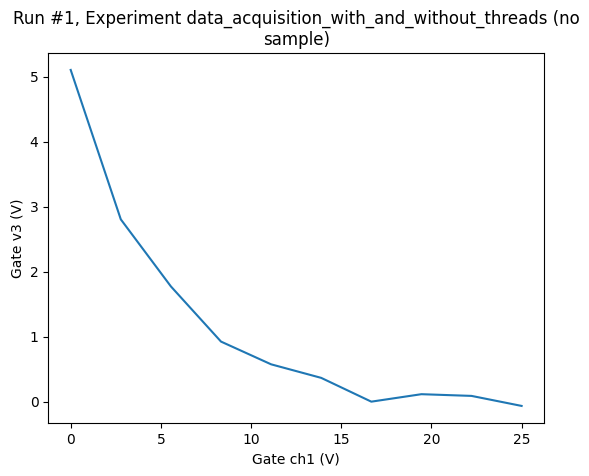

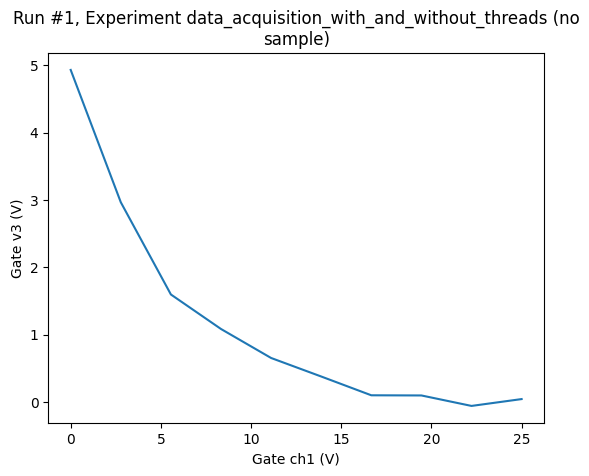

In [9]:
ax, cbax = plot_dataset(dataset1D1)

## Measurement 2: Threaded data acquisition

In this measurement, we use `ThreadPoolParamsCaller` for threaded data acquisition. Here also we record the time taken for data acquisition.

`ThreadPoolParamsCaller` will create a thread pool, and will call given parameters in those threads. Each group of parameters that have the same ``underlying_instrument`` protperty will be called in it's own separate thread, so that parameters that interact with the same instrument are always called sequentially (since communication within the single instrument is not thread-safe). Thanks to the fact that the pool of threads gets reuse for every new call of the parameters, the performance penalty of creating and shutting down threads is not significant in many cases.

If there is a benefit in creating new threads for every new parameter call, then use ``call_params_threaded`` function instead.

In [10]:
meas2 = Measurement(exp=exp, name='exponential_decay_threaded_data_acquisition')
meas2.register_parameter(dac.ch1)
meas2.register_parameter(dmm1.v3, setpoints=(dac.ch1,))
meas2.register_parameter(dmm2.v3, setpoints=(dac.ch1,))

In [11]:
pool_caller = ThreadPoolParamsCaller(dac.ch1, dmm1.v3, dmm2.v3)  # <----- This line is different

data_acq_time = 0
with meas2.run() as datasaver, pool_caller as call_params_in_pool:  # <----- This line is different
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)

        t1 = time.perf_counter()
        datasaver.add_result(*call_params_in_pool())  # <----- This line is different
        t2 = time.perf_counter()

        data_acq_time += t2 - t1

        # With ``call_params_threaded`` this line that measures parameters
        # and passes them to the datasaver would be:
        # datasaver.add_result(*call_params_threaded((dac.ch1, dmm1.v3, dmm2.v3)))

    dataset1D2 = datasaver.dataset

print('Report:')
print(f'Data acquisition time:            {data_acq_time} s')

Starting experimental run with id: 2. 


Report:
Data acquisition time:            1.008101162999992 s


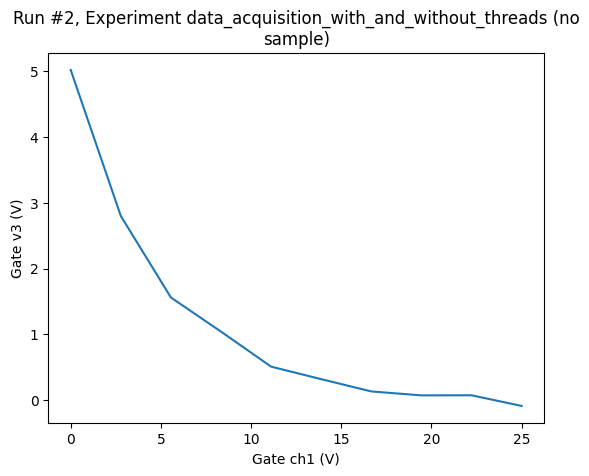

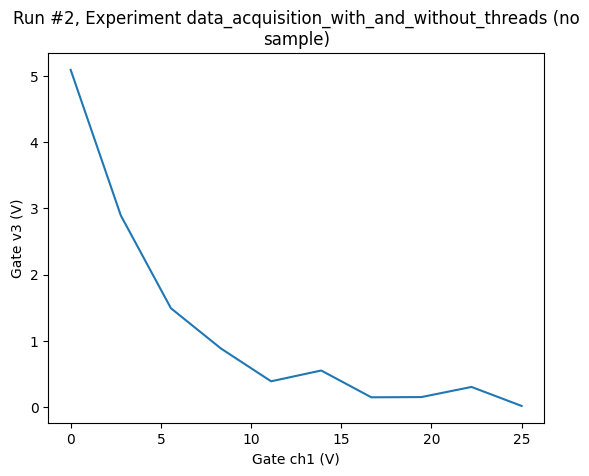

In [12]:
ax, cbax = plot_dataset(dataset1D2)

## Non threaded and threaded data acquisition with do1d

Lets now see how to do non threaded and threaded data acquisition with `do1d` function. For threaded data acquisition, `use_threads` argument will be set to `True`. Same argument is available on `do0d`, `do2d` and `dond` functions.

### Measurement 3: Non threaded data acquisition with do1d

Starting experimental run with id: 3. Using 'qcodes.dataset.do1d'


Report:
Data acquisition time:            3.1794520770000076 s


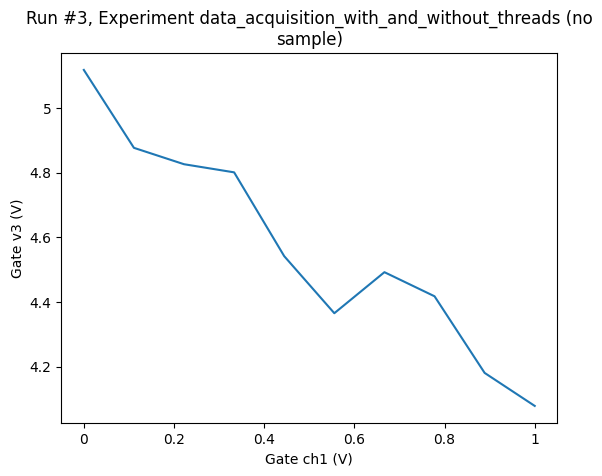

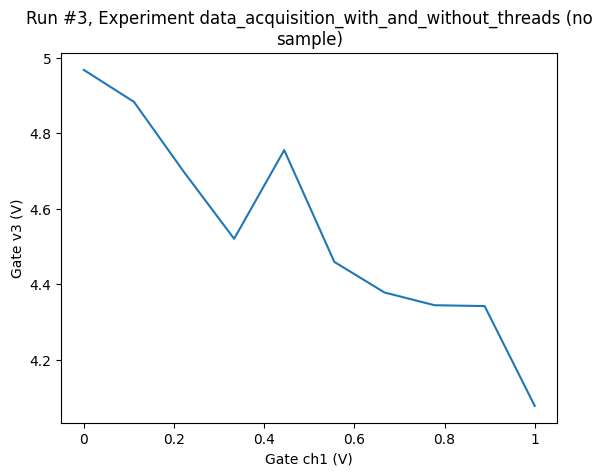

In [13]:
t0 = time.perf_counter()
do1d(dac.ch1, 0, 1, 10, 0, dmm1.v3, dmm2.v3, do_plot=True)
t1 = time.perf_counter()

print('Report:')
print(f'Data acquisition time:            {t1 - t0} s')

###  Measurement 4: Threaded data acquisition with do1d

Starting experimental run with id: 4. Using 'qcodes.dataset.do1d'


Report:
Data acquisition time:            2.0638123609999752 s


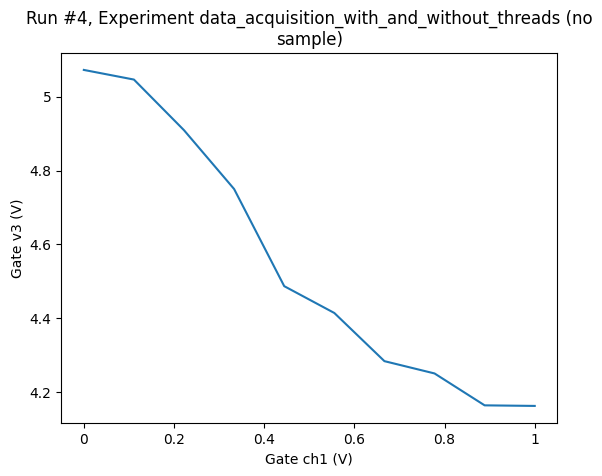

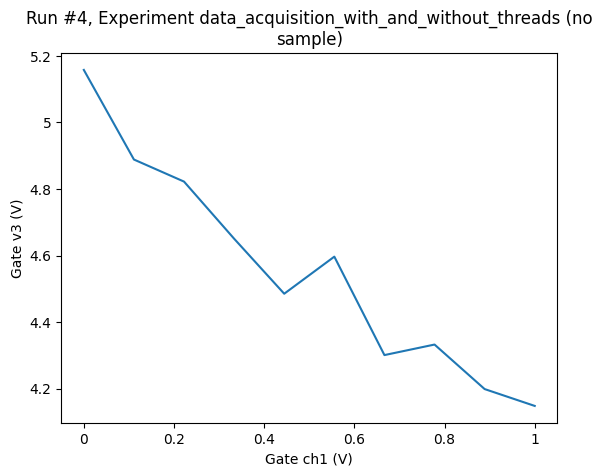

In [14]:
t0 = time.perf_counter()
do1d(dac.ch1, 0, 1, 10, 0, dmm1.v3, dmm2.v3, do_plot=True, use_threads=True) # <------- This line is different
t1 = time.perf_counter()

print('Report:')
print(f'Data acquisition time:            {t1 - t0} s')